

**Low Light Image Enhancement Using GladNet**



#Install

In [1]:
!pip install torch torchvision opencv-python numpy matplotlib tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

#The necessary classes

In [1]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class LOLDataset(Dataset):
    def __init__(self, root_dir, split="train", transform=None):
        """
        Args:
            root_dir (str): Path to the LOL Dataset (v1).
            split (str): "train" or "test".
            transform (callable, optional): Optional transforms.
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.low_dir = os.path.join(root_dir, split, "low")
        self.high_dir = os.path.join(root_dir, split, "high")
        self.image_names = os.listdir(self.low_dir)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        low_img_path = os.path.join(self.low_dir, self.image_names[idx])
        high_img_path = os.path.join(self.high_dir, self.image_names[idx])

        # Read images (BGR to RGB)
        low_img = cv2.cvtColor(cv2.imread(low_img_path), cv2.COLOR_BGR2RGB)
        high_img = cv2.cvtColor(cv2.imread(high_img_path), cv2.COLOR_BGR2RGB)

        # Normalize to [0, 1]
        low_img = low_img.astype(np.float32) / 255.0
        high_img = high_img.astype(np.float32) / 255.0

        # Convert to PyTorch tensors (HWC to CHW)
        low_img = torch.from_numpy(low_img).permute(2, 0, 1)
        high_img = torch.from_numpy(high_img).permute(2, 0, 1)

        if self.transform:
            low_img = self.transform(low_img)
            high_img = self.transform(high_img)

        return low_img, high_img

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np

class GLADNet(nn.Module):
    def __init__(self):
        super(GLADNet, self).__init__()
        # Global Path
        self.global_conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3)
        self.global_conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.global_conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.global_deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.global_deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.global_deconv3 = nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3)

        # Local Path
        self.local_conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.local_conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.local_conv3 = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)

        # Fusion
        self.fusion_conv = nn.Conv2d(6, 3, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        # Global Path
        g1 = F.relu(self.global_conv1(x))
        g2 = F.relu(self.global_conv2(g1))
        g3 = F.relu(self.global_conv3(g2))
        g4 = F.relu(self.global_deconv1(g3))
        g5 = F.relu(self.global_deconv2(g4 + g2))  # Skip connection
        global_out = torch.sigmoid(self.global_deconv3(g5 + g1))

        # Local Path
        l1 = F.relu(self.local_conv1(x))
        l2 = F.relu(self.local_conv2(l1))
        local_out = torch.sigmoid(self.local_conv3(l2 + l1))  # Skip connection

        # Fusion
        fused = torch.cat([global_out, local_out], dim=1)
        out = torch.sigmoid(self.fusion_conv(fused))
        return out

In [3]:
import torch.optim as optim
from tqdm import tqdm

def train_gladnet(root_dir, epochs=50, batch_size=4, lr=1e-4,model_path=None):
    # Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Dataset & DataLoader
    train_dataset = LOLDataset(root_dir, split="train")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Model, Loss, Optimizer
    model = GLADNet().to(device)
    try:
      model.load_state_dict(torch.load(model_path, map_location=device))
      print("Model loaded successfully")
    except Exception as e:
      print(f"Error loading model: {e}")

    criterion = nn.L1Loss()  # MAE loss (performs better for low-light enhancement)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for low_imgs, high_imgs in progress_bar:
            low_imgs = low_imgs.to(device)
            high_imgs = high_imgs.to(device)

            # Forward pass
            outputs = model(low_imgs)
            loss = criterion(outputs, high_imgs)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix(loss=running_loss / len(train_loader))

        # Save checkpoint
        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), f"/content/drive/MyDrive/Colab Notebooks/Computer Vision/Lol_Dataset/Models/gladnet_epoch_{epoch+1}.pth")

    print("Training complete!")
    return model

In [4]:
import matplotlib.pyplot as plt

In [5]:
def infer_and_visualize(model, image_path, device=None):
    """
    Args:
        model: Trained GLADNet model.
        image_path: Path to the low-light image.
        device: Optional (e.g., "cuda" or "cpu"). Auto-detects if None.
    """
    # Device setup
    if device is None:
        device = next(model.parameters()).device  # Same as model's device

    # Load and preprocess image
    low_img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    low_img = low_img.astype(np.float32) / 255.0
    low_tensor = torch.from_numpy(low_img).permute(2, 0, 1).unsqueeze(0).to(device)  # Move to device

    # Inference
    model.eval()
    with torch.no_grad():
        enhanced_tensor = model(low_tensor)

    # Move output back to CPU for visualization
    enhanced_img = enhanced_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    enhanced_img = (enhanced_img * 255).clip(0, 255).astype(np.uint8)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Low-Light Input")
    plt.imshow(low_img)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("GLADNet Enhanced")
    plt.imshow(enhanced_img)
    plt.axis("off")
    plt.show()

#Train

In [6]:
# Path to LOL Dataset (v1)
root_dir = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/Lol_Dataset/Data/lol_dataset"  # Replace with your path

In [7]:
model_path = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/Lol_Dataset/Models/gladnet_final.pth"

In [ ]:

model = train_gladnet(root_dir, epochs=300, batch_size=4,model_path=model_path)

Model loaded successfully


Epoch 206/300:  20%|██        | 25/122 [00:14<00:57,  1.68it/s, loss=0.0236]

#Load model and test

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# Load model (ensure it's on the right device)
# model = GLADNet().cuda()  # or .cpu()
model = GLADNet().to(device)

In [10]:
model_path = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/Lol_Dataset/Models/gladnet_epoch_200.pth"

In [11]:
model.load_state_dict(torch.load(model_path, map_location=device))


<All keys matched successfully>

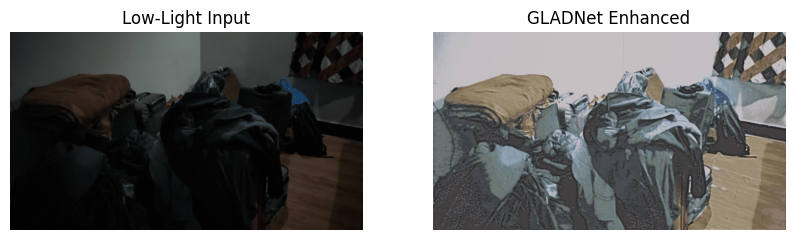

In [13]:

# Run inference
infer_and_visualize(model, "/content/2 (1).png")